In [14]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from rfpimp import oob_regression_r2_score

import xgboost as xgb

# 0. set parameters
fts = 10  # features shown in plot
thr = 0.05

In [16]:
# 1. get data
'''
agg_data = pd.read_csv('data_include_all_features.csv')
agg_data = agg_data.drop(columns=['V1', 'year', 'quarter', 'GEOID', 'lat', 'lng', 'NAME'])
X_train, X_test, y_train, y_test = train_test_split(agg_data.drop(columns='N'), agg_data['N'], test_size=0.2)
'''
agg_data = pd.read_csv("crime_data\\crime_assualt_data_yearly.csv", index_col=0)
agg_data = agg_data.drop(columns=['year', 'GEOID'])
X_train, X_test, y_train, y_test = train_test_split(agg_data.drop(columns='crime'), agg_data['crime'], test_size=0.2)

X_train[np.isnan(X_train)] = 0  # robbery documented as NA when it's zero
X_test[np.isnan(X_test)] = 0
X_train['random'] = np.random.random(size=len(X_train))  # add a column of random numbers
X_test['random'] = np.random.random(size=len(X_test))

rf = xgb.XGBRegressor(objective="reg:linear", n_estimators=100, booster="gbtree")
rf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

Feature ranking:
1. feature 67 : Income_in_the_past_12_months_below_poverty_level_Male (0.171603)
2. feature 71 : Income_in_the_past_12_months_below_poverty_level_Male_Not_in_labor_force (0.092700)
3. feature 88 : Male_50_to_54_years (0.063504)
4. feature 173 : school_SFCCD (0.043128)
5. feature 127 : Not_Hispanic_or_Latino_Black_or_African_American_alone (0.038846)
6. feature 27 : Female_80_to_84_years (0.037622)
7. feature 177 : N_calls_311 (0.033611)
8. feature 159 : prop_male (0.033480)
9. feature 61 : Income_in_the_past_12_months_below_poverty_level (0.029299)
10. feature 165 : racial_index (0.026419)

Random feature importance: 0.000000


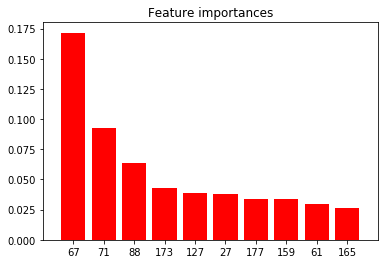

In [17]:
# 2. plot feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:fts]

# Print the feature ranking
print("Feature ranking:")

for f in range(fts):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], X_train.columns.values[indices[f]], importances[indices[f]]))
print("\nRandom feature importance: %f" % importances[-1])
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(fts), importances[indices],
       color="r", align="center")
plt.xticks(range(fts), indices)
plt.xlim([-1, fts])
plt.show()

In [18]:
# 3 feature selection
sel = SelectFromModel(xgb.XGBRegressor(objective="reg:linear", n_estimators=100, booster="gbtree"), threshold=thr)
sel.fit(X_train, y_train)

selected_feat = X_train.columns[(sel.get_support())]
n_features = len(selected_feat)
print(selected_feat)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Index(['Income_in_the_past_12_months_below_poverty_level_Male',
       'Income_in_the_past_12_months_below_poverty_level_Male_Not_in_labor_force',
       'Male_50_to_54_years'],
      dtype='object')


In [19]:
# 4: other importance
# 4.1 permutation importance
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

importances = permutation_importances(rf, X_train, y_train, oob_regression_r2_score)
indices = np.argsort(importances)[::-1][:fts]

# Print the feature ranking
print("Feature ranking:")

for f in range(fts):
    print("%d. feature %d : %s (%f)" % (f + 1, indices[f], X_train.columns.values[indices[f]], importances[indices[f]]))
print("\nRandom feature importance: %f" % importances[-1])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(fts), importances[indices],
       color="r", align="center")
plt.xticks(range(fts), indices)
plt.xlim([-1, fts])
plt.show()

AttributeError: 'XGBRegressor' object has no attribute 'estimators_'

In [20]:
# 4.2 drop-column importance
def dropcol_importances(rf, X_train, y_train):
    rf_ = copy.deepcopy(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = copy.deepcopy(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

importances = dropcol_importances(rf, X_train, y_train)

# Print the feature ranking
print("Feature ranking:")

for f in range(fts):
    print("%d. %s (%f)" % (f + 1, importances.index.values[f], importances.iloc[f, 0]))
print("\nRandom feature importance: %f" % importances.loc['random', 'Importance'])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(fts), importances.iloc[0:fts, 0],
       color="r", align="center")
plt.xticks(range(fts), ["ft. %d." % (f + 1) for f in range(fts)])
plt.xlim([-1, fts])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


AttributeError: 'XGBRegressor' object has no attribute 'oob_score_'